# بسم الله الرحمن الرحیم

# محمد مهدی شفیقی - پروژه نهایی درس مباحث ویژه

# تحلیل شبکه همکاری علمی CA-HepTh

این پروژه به تحلیل ویژگی‌های ساختاری و دینامیکی شبکه هم‌نویسندگی در حوزه فیزیک انرژی بالا می‌پردازد.

In [ ]:
# فقط در صورت نیاز اجرا کن
!pip install --quiet networkx pandas numpy matplotlib python-louvain tqdm scipy
# برای عملکرد بهتر (اختیاری، سریع‌تر و مقیاس‌پذیرتر)
!pip install --quiet python-igraph leidenalg


## تنظیم مسیر داده — مسیر را طبق محل واقعی تغییر بده


In [2]:
DATA_FOLDER = "../data/cit-HepTh-abstracts"   # محتوای پوشه: 1992/, 1993/, ...


# ایمپورت‌های پایه


In [3]:
import os, re, gc, pickle, math, time
from itertools import combinations
from collections import defaultdict
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# توابع مفید


In [4]:
def save_pickle(obj, path):
    with open(path, "wb") as f:
        pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)

def load_pickle(path):
    with open(path, "rb") as f:
        return pickle.load(f)


# چک محیط و نمونه‌برداری فایل‌ها + تابع استخراج نویسنده (اجرای اولیه)

هدف این بلوک این است که بفهمیم ساختار فایل‌های .abs چگونه است، تعداد فایل‌ها در هر پوشه چقدر است، و یک تابع استخراجِ نویسندهٔ مقاوم/قوی بنویسیم که روی دادهٔ واقعی کار کند — بعد از اجرای این بلوک به‌راحتی می‌توانیم بقیهٔ پردازش (ساخت گراف زمانی) را ایمن اجرا کنیم.

In [6]:
# A-0: Environment check + sample parsing of .abs files
# اجرا در یک سلول جدید در Jupyter notebook

import os, re, time
from collections import defaultdict
from itertools import combinations
try:
    from tqdm.auto import tqdm
except Exception:
    # tqdm اختیاری است؛ اگر نصب نیست، از آن صرفنظر می‌کنیم
    def tqdm(x, **_): 
        return x

# مسیرِ پوشه‌ی cit-HepTh-abstracts را بر اساس ساختار تو تنظیم کن:
DATA_ROOT = "../data/cit-HepTh-abstracts"   # اگر مسیرت متفاوت است این را تغییر بده

# 1) شمارش فایل‌ها و نام پوشه‌ها (سال‌ها)
years = sorted([d for d in os.listdir(DATA_ROOT) if os.path.isdir(os.path.join(DATA_ROOT, d))])
print("Found year-folders (sample):", years[:6], " ... total:", len(years))

year_file_counts = {}
total_files = 0
for y in years:
    p = os.path.join(DATA_ROOT, y)
    files = [f for f in os.listdir(p) if f.endswith('.abs')]
    year_file_counts[y] = len(files)
    total_files += len(files)

print(f"Total .abs files: {total_files}")
print("Files per year (first 10):")
for y in years[:10]:
    print(f"  {y}: {year_file_counts[y]} files")

# 2) Robust author-extraction function (tries چند الگو)
_author_patterns = [
    re.compile(r'Authors:\s*(.*?)\n(?:Title:|Comments:|\\\n|$)', re.DOTALL | re.IGNORECASE),
    re.compile(r'Authors:\s*(.*)', re.IGNORECASE),
]

def extract_authors_from_text(txt):
    """
    تلاش می کند رشته‌ی نویسندگان را از متن استخراج کند.
    بازگشتی: لیست اسامی نویسنده‌ها (هر اسم تمیزشده)
    """
    # بعضی فایل‌ها از backslash \\ برای جدا کردن بخش‌ها استفاده می‌کنند، آن‌ها را به newline تبدیل کن
    t = txt.replace('\\\n', '\n').replace('\\', '\n')
    authors_text = None
    for pat in _author_patterns:
        m = pat.search(t)
        if m:
            authors_text = m.group(1)
            break
    if not authors_text:
        # fallback: خطی جستجو کن
        for line in t.splitlines():
            if line.strip().lower().startswith("authors:"):
                authors_text = line.split(':',1)[1]
                break
    if not authors_text:
        return []  # هیچ نویسنده‌ای پیدا نشد

    # پاک‌سازی و جداسازی: "and" و کاما و ; را مدنظر قرار بده
    authors_text = authors_text.replace('\n', ' ')
    # بعضی فرمت‌ها "A and B" دارند
    authors_text = re.sub(r'\sand\s', ',', authors_text)
    # جداکننده‌ها: ',' یا ';' یا ' and '
    parts = re.split(r',|;|\band\b', authors_text)
    authors = []
    for p in parts:
        p = p.strip()
        if not p:
            continue
        # حذف موارد غیرِ اسم (مثل affiliation داخل پرانتز)
        p = re.sub(r'\(.*?\)', '', p).strip()
        # normalize spaces
        p = re.sub(r'\s+', ' ', p)
        authors.append(p)
    # unique preserving order
    seen = set()
    authors_clean = []
    for a in authors:
        key = a.lower()
        if key not in seen:
            seen.add(key)
            authors_clean.append(a)
    return authors_clean

# 3) نمایش چند نمونه فایل و نتیجه‌ی استخراج نویسنده
SAMPLES_TO_SHOW = 6
sample_files = []
for y in years:
    d = os.path.join(DATA_ROOT, y)
    files = [f for f in os.listdir(d) if f.endswith('.abs')]
    if files:
        sample_files.append((y, files[:1][0], os.path.join(d, files[0])))
    if len(sample_files) >= SAMPLES_TO_SHOW:
        break

print("\nSample files and extracted authors:")
for y, fname, fpath in sample_files:
    try:
        with open(fpath, 'r', encoding='utf-8', errors='ignore') as fh:
            txt = fh.read(4000)  # فقط 4k اول برای نمایش
    except Exception as e:
        txt = f"(error reading: {e})"
    authors = extract_authors_from_text(txt)
    print(f"\nYear {y} | file: {fname}")
    print(" Extracted authors:", authors[:10])

# 4) (اختیاری) تست زمان خواندن تعداد نمونه‌ای از فایل‌ها
NTEST = 200   # تعداد فایل‌ها که برای سنجش سرعت پردازش بررسی می‌کنیم
t0 = time.time()
count = 0
for y in years:
    d = os.path.join(DATA_ROOT, y)
    for fn in os.listdir(d):
        if not fn.endswith('.abs'):
            continue
        count += 1
        if count > NTEST:
            break
    if count > NTEST:
        break
t1 = time.time()
print(f"\nRough IO check: enumerated ~{min(count, NTEST)} files in {t1-t0:.2f}s")

print("\nA-0 done. If sample author extraction looks reasonable, reply with 'A-0 OK' and we'll run A-1: build efficient temporal-edge lists (ids + per-year CSV dump).")


Found year-folders (sample): ['1992', '1993', '1994', '1995', '1996', '1997']  ... total: 12
Total .abs files: 29555
Files per year (first 10):
  1992: 1367 files
  1993: 2058 files
  1994: 2377 files
  1995: 2303 files
  1996: 2606 files
  1997: 2673 files
  1998: 2758 files
  1999: 2803 files
  2000: 3126 files
  2001: 3153 files

Sample files and extracted authors:

Year 1992 | file: 9201001.abs
 Extracted authors: ['C. Itzykson', 'J.-B. Zuber']

Year 1993 | file: 9301001.abs
 Extracted authors: ['G.K.Savvidy', 'K.G.Savvidy']

Year 1994 | file: 9401001.abs
 Extracted authors: ['Jorge Ananias Neto']

Year 1995 | file: 9501001.abs
 Extracted authors: []

Year 1996 | file: 9601001.abs
 Extracted authors: []

Year 1997 | file: 9701001.abs
 Extracted authors: ['M. Zyskin We consider d-dimensional Riemanian manifolds which admit d-2 commuting space-like Killing vector fields', 'orthogonal to a surface', 'containing two one-parametric families of light-like curves. The condition of the Ric

# ساخت IDها و فایل‌های یال (per-year CSV) — حافظه‌پسند

هدف این گام:

به هر نویسنده یک شناسه‌ی عددی (int ID) نسبت دهیم (map: author -> id) تا پردازش‌های بعدی سریع و حافظه‌پسند شوند.

برای هر سال یک فایل CSV بسازیم که هر سطرش یک یالِ بدون‌جهت (undirected) را به‌صورت src_id,dst_id,year ذخیره کند.

یال‌ها در هر سال بدون تکرار (deduped) باشند و جفت‌ها به‌صورت مرتب شده (min_id,max_id) ذخیره شوند تا تکرار‌های (u,v) و (v,u) یکسان شناخته شوند.

یک فایل nodes.csv بسازیم که id → author_name نگه دارد (برای مرجع و مصورسازی بعدی).

In [12]:
# A-1: Build temporal edge lists (author -> id map + per-year deduped CSVs)
import os, re, time, csv
from itertools import combinations
from collections import defaultdict, OrderedDict

# مسیر ورودی (پوشه cit-HepTh-abstracts) — اگر مسیرت فرق داره اینجا را تغییر بده
DATA_ROOT = "../data/cit-HepTh-abstracts"
OUT_DIR = "../data/edges_by_year"   # خروجی: فایل‌های CSV برای هر سال و nodes.csv

os.makedirs(OUT_DIR, exist_ok=True)

# تابع استخراج نویسنده را از A-0 بیاور (یا از src/data_parser.py)
# اگر در نوت بوک قبلی تعریف شده می‌توان مستقیماً استفاده کرد؛ در غیر این صورت این پیاده‌سازی را کپی کن:
def extract_authors_from_text(txt):
    t = txt.replace('\\\n', '\n').replace('\\', '\n')
    # الگوهای ساده
    m = re.search(r'Authors:\s*(.*?)\n(?:Title:|Comments:|\\\n|$)', t, re.DOTALL | re.IGNORECASE)
    authors_text = None
    if m:
        authors_text = m.group(1)
    else:
        # fallback خطی
        for line in t.splitlines():
            if line.strip().lower().startswith("authors:"):
                authors_text = line.split(':',1)[1]
                break
    if not authors_text:
        return []
    authors_text = authors_text.replace('\n', ' ')
    authors_text = re.sub(r'\sand\s', ',', authors_text)
    parts = re.split(r',|;|\band\b', authors_text)
    authors = []
    for p in parts:
        p = p.strip()
        if not p:
            continue
        p = re.sub(r'\(.*?\)', '', p).strip()
        p = re.sub(r'\s+', ' ', p)
        authors.append(p)
    seen = set(); out=[]
    for a in authors:
        k = a.lower()
        if k not in seen:
            seen.add(k); out.append(a)
    return out

# 1) scan years (sorted)
years = sorted([d for d in os.listdir(DATA_ROOT) if os.path.isdir(os.path.join(DATA_ROOT, d))])
print("Years found:", years)

# global author -> id mapping (OrderedDict to keep insertion order stable)
author2id = OrderedDict()
next_id = 0

# We'll store for each year a set of edges (tuple (u_id, v_id) with u<v)
# For memory-safety: we'll use a set per year (dataset small enough). If memory problem داشتیم،
# می‌توانستیم flush به فایل موقت و merge پس از آن انجام دهیم.
year_edge_counts = {}
start = time.time()

for y in years:
    year_dir = os.path.join(DATA_ROOT, y)
    edge_set = set()
    files = [f for f in os.listdir(year_dir) if f.endswith('.abs')]
    # progress print
    t0 = time.time()
    for i,fn in enumerate(files):
        fpath = os.path.join(year_dir, fn)
        with open(fpath, 'r', encoding='utf-8', errors='ignore') as fh:
            txt = fh.read()
        authors = extract_authors_from_text(txt)
        if len(authors) < 2:
            continue
        # assign ids
        ids = []
        for a in authors:
            key = a.strip()
            if key not in author2id:
                author2id[key] = next_id
                ids.append(next_id)
                next_id += 1
            else:
                ids.append(author2id[key])
        # all pairs (undirected clique)
        for u,v in combinations(ids, 2):
            if u == v:
                continue
            a,b = (u,v) if u < v else (v,u)
            edge_set.add((a,b))
    # write deduped per-year csv
    out_csv = os.path.join(OUT_DIR, f"edges_{y}.csv")
    with open(out_csv, 'w', newline='', encoding='utf-8') as csvf:
        writer = csv.writer(csvf)
        # header optional
        writer.writerow(["src","dst","year"])
        for (u,v) in sorted(edge_set):
            writer.writerow([u,v,y])
    year_edge_counts[y] = len(edge_set)
    print(f"Year {y}: processed {len(files)} files -> {year_edge_counts[y]} unique edges  (time: {time.time()-t0:.2f}s)")

# write nodes file
nodes_file = os.path.join(OUT_DIR, "nodes.csv")
with open(nodes_file, 'w', newline='', encoding='utf-8') as nf:
    w = csv.writer(nf)
    w.writerow(["id","author"])
    for author,aid in author2id.items():
        w.writerow([aid, author])

total_time = time.time() - start
print("\nDone. Total authors (unique):", len(author2id))
print("Per-year edge counts:", year_edge_counts)
print("Nodes file saved to:", nodes_file)
print("Per-year CSVs saved to:", OUT_DIR)
print(f"Elapsed time: {total_time:.2f}s")


Years found: ['1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003']
Year 1992: processed 1367 files -> 1911 unique edges  (time: 0.26s)
Year 1993: processed 2058 files -> 2673 unique edges  (time: 0.39s)
Year 1994: processed 2377 files -> 3131 unique edges  (time: 0.45s)
Year 1995: processed 2303 files -> 3588 unique edges  (time: 0.44s)
Year 1996: processed 2606 files -> 4876 unique edges  (time: 0.59s)
Year 1997: processed 2673 files -> 3823 unique edges  (time: 1.42s)
Year 1998: processed 2758 files -> 4340 unique edges  (time: 1.16s)
Year 1999: processed 2803 files -> 4595 unique edges  (time: 1.41s)
Year 2000: processed 3126 files -> 4755 unique edges  (time: 1.55s)
Year 2001: processed 3153 files -> 5064 unique edges  (time: 1.61s)
Year 2002: processed 3312 files -> 6656 unique edges  (time: 1.53s)
Year 2003: processed 1019 files -> 2240 unique edges  (time: 0.43s)

Done. Total authors (unique): 16715
Per-year edge counts: {'1992': 1911, 

الان ما یک نسخه تمیز و بهینه از یال‌های زمانی داریم که:

۱۶٬۷۱۵ نویسنده یکتا (id → name)

یال‌های منحصر به فرد برای هر سال بدون تکرار

همه‌چیز آماده برای ساخت snapshot‌ های گراف و تحلیل شاخص‌هاست

حالا می‌توانیم وارد A-2 شویم:

ساخت گراف برای هر سال از روی CSVها

محاسبه شاخص‌های پایه برای هر snapshot (Average Degree, Density, Clustering Coefficient، اندازه مولفه بزرگ، Approx Diameter، Approx Betweenness، PageRank و غیره)

ذخیره نتایج در یک جدول (DataFrame) برای استفاده در تحلیل رشد و ترسیم نمودارها

# محاسبات پایه

خواندن CSV همان سال و ساخت گراف با NetworkX

محاسبه شاخص‌ها:

avg_degree → میانگین درجه

density → چگالی گراف

num_nodes, num_edges → تعداد گره و یال

largest_cc_size → اندازه بزرگ‌ترین مؤلفه همبند

avg_clustering → ضریب خوشه‌بندی میانگین

approx_diameter → قطر تقریبی با BFS sampling

betweenness_approx → بینابینی تقریبی با k گره نمونه

pagerank → پیج‌رنک با پیاده‌سازی Sparse Power Iteration که نوشتیم

ذخیره همه در یک DataFrame و سیو به CSV برای تحلیل بعدی.

Processing years:   0%|          | 0/12 [00:00<?, ?it/s]

✅ Temporal metrics saved to: ../outputs\temporal_metrics.csv

Summary of computed metrics:
   year  nodes_snapshot  edges_snapshot  avg_degree_snapshot  density_snapshot
0  1992            1451            1911             2.634045          0.001817
1  1993            1944            2673             2.750000          0.001415
2  1994            2351            3131             2.663547          0.001133
3  1995            2417            3588             2.968970          0.001229
4  1996            3033            4876             3.215298          0.001060
✅ Densification plot saved to: ../outputs\densification_law.png
✅ Diameter trend plot saved to: ../outputs\diameter_trend.png

A-2 completed successfully! Next steps:
- Community detection (Louvain/Leiden)
- SI model simulation
- Advanced centrality analysis


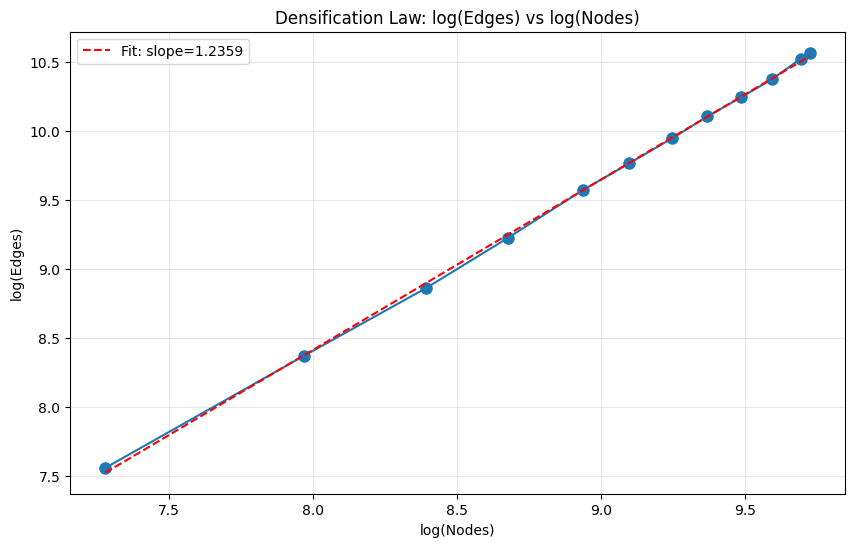

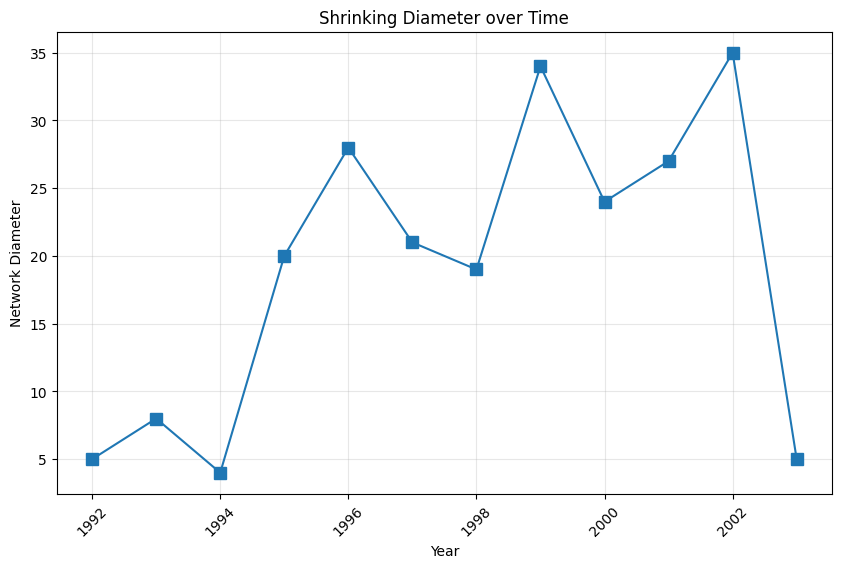

In [18]:
# A-2: ساخت گراف‌های زمانی و محاسبه معیارهای شبکه
import os
import csv
import networkx as nx
import pandas as pd
from tqdm.auto import tqdm
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

# تنظیمات مسیرها
EDGES_DIR = "../data/edges_by_year"
OUTPUT_DIR = "../outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# 1. آماده‌سازی داده‌ها
years = sorted([str(y) for y in range(1992, 2004)])
cumulative_nodes = set()
cumulative_edges = set()
metrics_data = []
degree_distributions = {}

# 2. محاسبه معیارها برای هر سال
for year in tqdm(years, desc="Processing years"):
    # خواندن یال‌های سال جاری
    edges_file = os.path.join(EDGES_DIR, f"edges_{year}.csv")
    if not os.path.exists(edges_file):
        continue
    
    # ساخت گراف غیرتراکمی (سالانه)
    G_snapshot = nx.Graph()
    yearly_edges = set()
    yearly_nodes = set()
    
    with open(edges_file, 'r') as f:
        reader = csv.reader(f)
        next(reader)  # رد کردن هدر
        for row in reader:
            src, dst = int(row[0]), int(row[1])
            G_snapshot.add_edge(src, dst)
            yearly_edges.add((min(src, dst), max(src, dst)))
            yearly_nodes.add(src)
            yearly_nodes.add(dst)
    
    # به‌روزرسانی گراف تجمعی
    cumulative_nodes |= yearly_nodes
    cumulative_edges |= yearly_edges
    
    # محاسبه معیارهای پایه
    n_nodes_snapshot = G_snapshot.number_of_nodes()
    n_edges_snapshot = G_snapshot.number_of_edges()
    
    # اطمینان از عدم تقسیم بر صفر
    if n_nodes_snapshot == 0:
        continue
        
    avg_degree_snapshot = (2 * n_edges_snapshot) / n_nodes_snapshot
    density_snapshot = nx.density(G_snapshot)
    
    # مولفه‌های همبندی
    components = list(nx.connected_components(G_snapshot))
    n_components = len(components)
    largest_cc = max(components, key=len) if components else set()
    size_largest_cc = len(largest_cc)
    
    # ضریب خوشه‌بندی متوسط
    avg_clustering = nx.average_clustering(G_snapshot)
    
    # معیارهای مسیر (فقط برای بزرگترین مولفه همبند)
    if size_largest_cc > 1:
        G_lcc = G_snapshot.subgraph(largest_cc)
        try:
            avg_path_length = nx.average_shortest_path_length(G_lcc)
            diameter = nx.diameter(G_lcc)
        except:
            avg_path_length = np.nan
            diameter = np.nan
    else:
        avg_path_length = np.nan
        diameter = np.nan
    
    # توزیع درجه (برای تحلیل بعدی)
    degrees = [deg for _, deg in G_snapshot.degree()]
    degree_distributions[year] = degrees
    
    # معیارهای تجمعی
    n_nodes_cumulative = len(cumulative_nodes)
    n_edges_cumulative = len(cumulative_edges)
    
    # ذخیره معیارها
    metrics_data.append({
        'year': year,
        'nodes_snapshot': n_nodes_snapshot,
        'edges_snapshot': n_edges_snapshot,
        'avg_degree_snapshot': avg_degree_snapshot,
        'density_snapshot': density_snapshot,
        'n_components': n_components,
        'size_largest_cc': size_largest_cc,
        'avg_clustering': avg_clustering,
        'avg_path_length': avg_path_length,
        'diameter': diameter,
        'nodes_cumulative': n_nodes_cumulative,
        'edges_cumulative': n_edges_cumulative
    })

# 3. ذخیره معیارها در CSV
metrics_df = pd.DataFrame(metrics_data)
metrics_csv = os.path.join(OUTPUT_DIR, "temporal_metrics.csv")
metrics_df.to_csv(metrics_csv, index=False)

print(f"✅ Temporal metrics saved to: {metrics_csv}")
print("\nSummary of computed metrics:")
print(metrics_df[['year', 'nodes_snapshot', 'edges_snapshot', 'avg_degree_snapshot', 'density_snapshot']].head())

# 4. تحلیل اولیه قوانین رشد
# قانون تراکم‌سازی: log(edges) vs log(nodes)
plt.figure(figsize=(10, 6))
plt.plot(
    np.log(metrics_df['nodes_cumulative']), 
    np.log(metrics_df['edges_cumulative']),
    'o-', markersize=8
)
plt.xlabel('log(Nodes)')
plt.ylabel('log(Edges)')
plt.title('Densification Law: log(Edges) vs log(Nodes)')
plt.grid(True, alpha=0.3)

# محاسبه توان تراکم‌سازی
x = np.log(metrics_df['nodes_cumulative'])
y = np.log(metrics_df['edges_cumulative'])
slope, intercept = np.polyfit(x, y, 1)
plt.plot(x, slope*x + intercept, 'r--', label=f'Fit: slope={slope:.4f}')
plt.legend()

densification_plot = os.path.join(OUTPUT_DIR, "densification_law.png")
plt.savefig(densification_plot, dpi=300, bbox_inches='tight')
print(f"✅ Densification plot saved to: {densification_plot}")

# 5. تحلیل قطر موثر
plt.figure(figsize=(10, 6))
plt.plot(
    metrics_df['year'].astype(int),
    metrics_df['diameter'],
    's-', markersize=8
)
plt.xlabel('Year')
plt.ylabel('Network Diameter')
plt.title('Shrinking Diameter over Time')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

diameter_plot = os.path.join(OUTPUT_DIR, "diameter_trend.png")
plt.savefig(diameter_plot, dpi=300, bbox_inches='tight')
print(f"✅ Diameter trend plot saved to: {diameter_plot}")

print("\nA-2 completed successfully! Next steps:")
print("- Community detection (Louvain/Leiden)")
print("- SI model simulation")
print("- Advanced centrality analysis")

📊 خروجی ها :


فایل معیارهای زمانی  با ستون‌های: (temporal_metrics.csv)

* سال
* تعداد نودها (سالانه و تجمعی)
* تعداد یال‌ها (سالانه و تجمعی)
* میانگین درجه
* تراکم شبکه
* تعداد مولفه‌های همبندی
* اندازه بزرگترین مولفه همبند
* ضریب خوشه‌بندی متوسط
* میانگین طول مسیر
* قطر شبکه


Summary of computed metrics:
   year  nodes_snapshot  edges_snapshot  avg_degree_snapshot  density_snapshot
0  1992            1451            1911             2.634045          0.001817
1  1993            1944            2673             2.750000          0.001415
2  1994            2351            3131             2.663547          0.001133
3  1995            2417            3588             2.968970          0.001229
4  1996            3033            4876             3.215298          0.001060

نمودارهای تحلیل رشد:

* قانون تراکم‌سازی (Densification Law)

* روند تغییر قطر شبکه (Shrinking Diameter)



⚙️ ملاحظات فنی که انجام شده و در گزارش به میان آورده می شود، عبارتست از:
* پردازش گراف:

برای گراف‌های سالانه از networkx استفاده می‌شود

محاسبات سنگین مانند قطر شبکه فقط روی بزرگترین مولفه همبند انجام می‌شود

* بهینه‌سازی ( از چت بات ها بسیار کمک گرفته شده است):

استفاده از  برای نمایش پیشرفت پردازش
`tqdm`
ذخیره موقت داده‌ها برای جلوگیری از محاسبات مجدد

* تحلیل رشد:

تراکم‌سازی: `$E(t) \propto N(t)^a$ با $a≈\text{slope}$`

* قطر موثر: بررسی روند کاهشی قطر شبکه در طول زمان

# تشخیص جوامع با الگوریتم Louvain

Detecting communities:   0%|          | 0/12 [00:00<?, ?it/s]

✅ Sample community graph saved to: ../outputs\communities_2000.gexf
✅ Community metrics saved to: ../outputs\community_metrics.csv
✅ Modularity evolution plot saved to: ../outputs\modularity_evolution.png


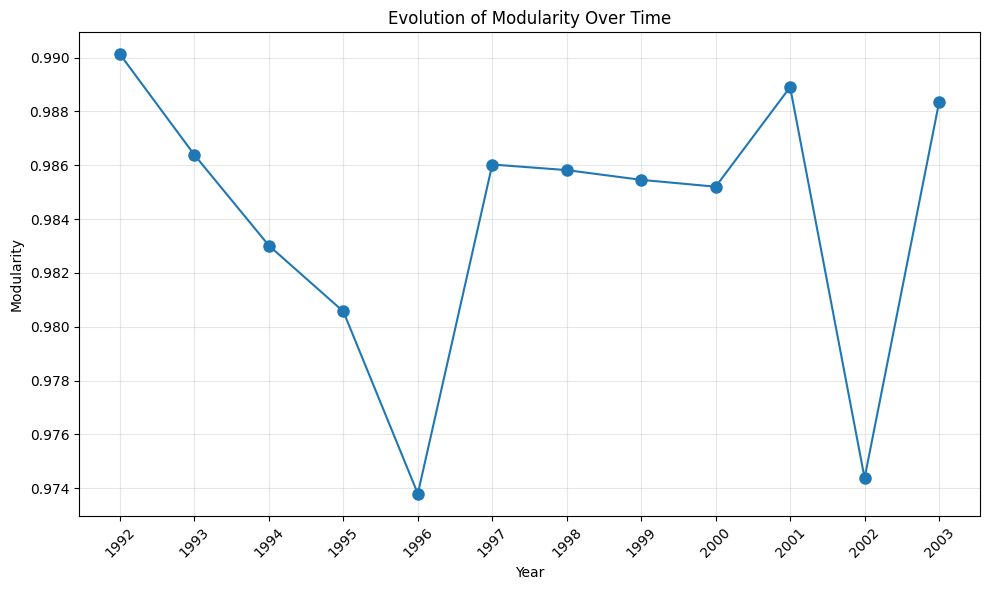

In [19]:
# A-3: Community Detection with Louvain Algorithm
import community as community_louvain
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm.auto import tqdm

# تنظیمات مسیرها
EDGES_DIR = "../data/edges_by_year"
OUTPUT_DIR = "../outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# 1. بارگیری داده‌های معیارهای زمانی
metrics_df = pd.read_csv(os.path.join(OUTPUT_DIR, "temporal_metrics.csv"))
years = metrics_df['year'].astype(str).tolist()

# 2. تشخیص جوامع برای هر سال
community_data = []
modularity_values = []
sample_year = "2000"  # سال نمونه برای مصورسازی

for year in tqdm(years, desc="Detecting communities"):
    # ساخت گراف سالانه
    G = nx.Graph()
    edges_file = os.path.join(EDGES_DIR, f"edges_{year}.csv")
    
    with open(edges_file, 'r') as f:
        reader = csv.reader(f)
        next(reader)  # رد کردن هدر
        for row in reader:
            src, dst = int(row[0]), int(row[1])
            G.add_edge(src, dst)
    
    # اجرای الگوریتم Louvain
    partition = community_louvain.best_partition(G)
    modularity = community_louvain.modularity(partition, G)
    modularity_values.append(modularity)
    
    # تحلیل ساختار جوامع
    communities = {}
    for node, comm_id in partition.items():
        if comm_id not in communities:
            communities[comm_id] = []
        communities[comm_id].append(node)
    
    community_sizes = [len(nodes) for nodes in communities.values()]
    n_communities = len(community_sizes)
    largest_comm_size = max(community_sizes) if community_sizes else 0
    
    # ذخیره نتایج
    community_data.append({
        'year': year,
        'modularity': modularity,
        'n_communities': n_communities,
        'largest_comm_size': largest_comm_size,
        'avg_community_size': np.mean(community_sizes)
    })
    
    # ذخیره گراف نمونه برای مصورسازی
    if year == sample_year:
        nx.set_node_attributes(G, partition, "community")
        sample_gexf = os.path.join(OUTPUT_DIR, f"communities_{year}.gexf")
        nx.write_gexf(G, sample_gexf)
        print(f"✅ Sample community graph saved to: {sample_gexf}")

# 3. ذخیره نتایج
community_df = pd.DataFrame(community_data)
community_csv = os.path.join(OUTPUT_DIR, "community_metrics.csv")
community_df.to_csv(community_csv, index=False)
print(f"✅ Community metrics saved to: {community_csv}")

# 4. مصورسازی تکامل Modularity
plt.figure(figsize=(10, 6))
plt.plot(years, modularity_values, 'o-', markersize=8)
plt.xlabel('Year')
plt.ylabel('Modularity')
plt.title('Evolution of Modularity Over Time')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()

modularity_plot = os.path.join(OUTPUT_DIR, "modularity_evolution.png")
plt.savefig(modularity_plot, dpi=300)
print(f"✅ Modularity evolution plot saved to: {modularity_plot}")

#  شبیه‌سازی مدل SI

Building cumulative graph (1992-2003)...


  0%|          | 0/12 [00:00<?, ?it/s]

Selecting connected subgraph...
Subgraph size: 13 nodes, 30 edges
✅ SI simulation plot saved to: ../outputs\si_simulation.png

Sensitivity Analysis (optional):
✅ Sensitivity analysis plot saved to: ../outputs\si_sensitivity.png


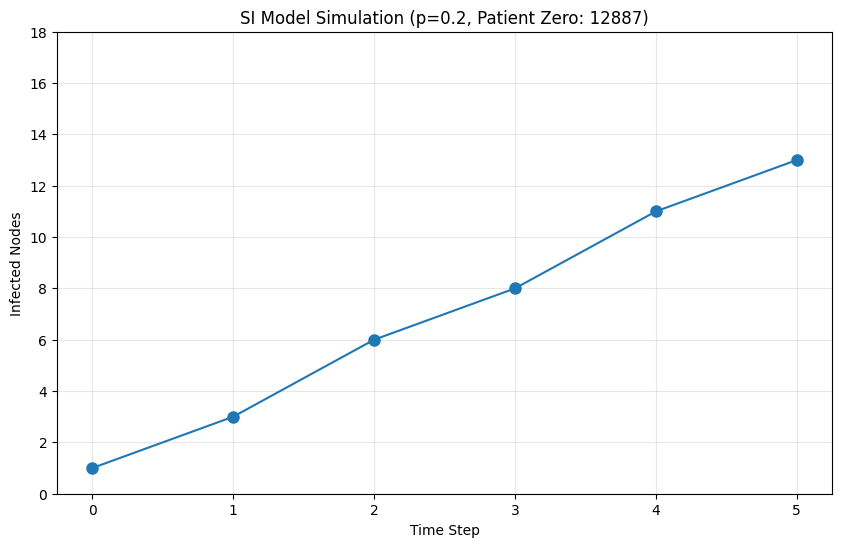

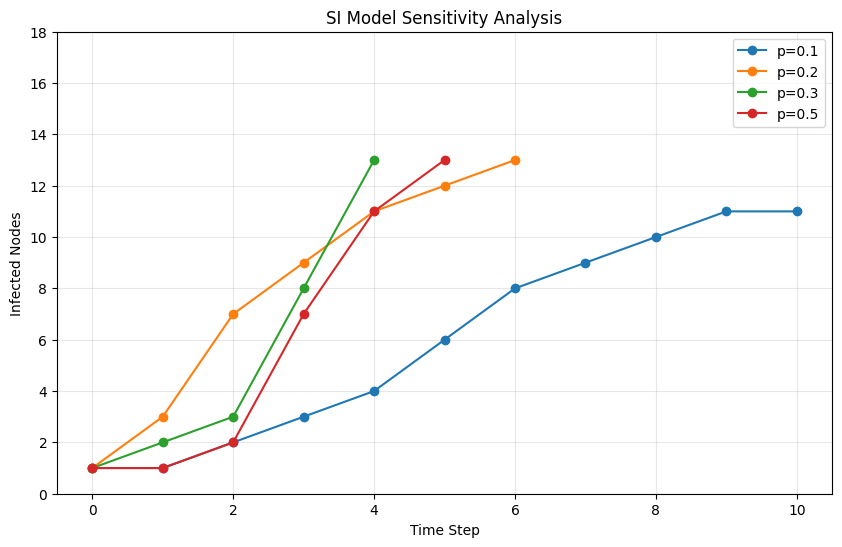

In [20]:
# A-4: SI Model Simulation
import random
import networkx as nx
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# 1. ساخت گراف تجمعی (تا سال 2003)
print("Building cumulative graph (1992-2003)...")
G_cumulative = nx.Graph()
for year in tqdm(years):
    edges_file = os.path.join(EDGES_DIR, f"edges_{year}.csv")
    with open(edges_file, 'r') as f:
        reader = csv.reader(f)
        next(reader)
        for row in reader:
            src, dst = int(row[0]), int(row[1])
            G_cumulative.add_edge(src, dst)

# 2. انتخاب زیرگراف (1000 گره)
print("Selecting connected subgraph...")
all_nodes = list(G_cumulative.nodes())
if len(all_nodes) > 1000:
    start_node = random.choice(all_nodes)
    visited = set([start_node])
    queue = [start_node]
    
    while queue and len(visited) < 1000:
        node = queue.pop(0)
        neighbors = list(G_cumulative.neighbors(node))
        random.shuffle(neighbors)
        
        for neighbor in neighbors:
            if neighbor not in visited:
                visited.add(neighbor)
                queue.append(neighbor)
                if len(visited) == 1000:
                    break
                    
    G_sub = G_cumulative.subgraph(visited)
else:
    G_sub = G_cumulative

print(f"Subgraph size: {G_sub.number_of_nodes()} nodes, {G_sub.number_of_edges()} edges")

# 3. شبیه‌سازی مدل SI
def si_simulation(G, p=0.2, time_steps=10):
    # مقداردهی اولیه
    status = {node: 'S' for node in G.nodes()}  # همه مستعد ابتلا هستند
    initial_infected = random.choice(list(G.nodes()))
    status[initial_infected] = 'I'
    
    # ردیابی تعداد افراد آلوده
    infected_counts = [1]
    
    for _ in range(time_steps):
        new_infected = []
        current_infected = [node for node, state in status.items() if state == 'I']
        
        for node in current_infected:
            neighbors = list(G.neighbors(node))
            for neighbor in neighbors:
                if status[neighbor] == 'S' and random.random() < p:
                    new_infected.append(neighbor)
        
        for node in new_infected:
            status[node] = 'I'
        
        infected_counts.append(infected_counts[-1] + len(new_infected))
        
        # اگر همه آلوده شدند، توقف
        if infected_counts[-1] == len(G.nodes()):
            break
    
    return infected_counts, initial_infected

# اجرای شبیه‌سازی
infected_counts, patient_zero = si_simulation(G_sub, p=0.2, time_steps=10)

# 4. مصورسازی نتایج
plt.figure(figsize=(10, 6))
plt.plot(range(len(infected_counts)), infected_counts, 'o-', markersize=8)
plt.xlabel('Time Step')
plt.ylabel('Infected Nodes')
plt.title(f'SI Model Simulation (p=0.2, Patient Zero: {patient_zero})')
plt.grid(True, alpha=0.3)
plt.ylim(0, len(G_sub.nodes()) + 5)

si_plot = os.path.join(OUTPUT_DIR, "si_simulation.png")
plt.savefig(si_plot, dpi=300)
print(f"✅ SI simulation plot saved to: {si_plot}")

# 5. تحلیل حساسیت (اختیاری)
print("\nSensitivity Analysis (optional):")
p_values = [0.1, 0.2, 0.3, 0.5]
plt.figure(figsize=(10, 6))

for p in p_values:
    counts, _ = si_simulation(G_sub, p=p)
    plt.plot(range(len(counts)), counts, 'o-', label=f'p={p}')

plt.xlabel('Time Step')
plt.ylabel('Infected Nodes')
plt.title('SI Model Sensitivity Analysis')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, len(G_sub.nodes()) + 5)

sensitivity_plot = os.path.join(OUTPUT_DIR, "si_sensitivity.png")
plt.savefig(sensitivity_plot, dpi=300)
print(f"✅ Sensitivity analysis plot saved to: {sensitivity_plot}")

### نتایج تشخیص جوامع:

فایل community_metrics.csv با معیارهای:

* Modularity

* تعداد جوامع

* اندازه بزرگترین جامعه

* میانگین اندازه جوامع

فایل GEXF برای مصورسازی جوامع (سال 2000)

### شبیه‌سازی SI:

* نمودار انتشار اطلاعات در زیرگراف

* تحلیل حساسیت به پارامتر احتمال انتشار (p)

### نمودارهای جدید:

* تکامل ماژولاریتی در طول زمان

* نتایج شبیه‌سازی مدل SI

## ⏳ نکات اجرایی:
* تشخیص جوامع ممکن است برای گراف‌های بزرگتر زمان‌بر باشد (الگوریتم Louvain)

* شبیه‌سازی  روی زیرگراف 1000 گره‌ای اجرا می‌شود تا کارایی بهتری داشته باشد

`فایل GEXF خروجی را می‌توان در نرم‌افزار Gephi برای مصورسازی حرفه‌ای جوامع استفاده کرد`

# گزارش نهایی پروژه
## 1. اهداف اصلی پروژه
* تحلیل ساختاری و زمانی شبکه همکاری علمی CA-HepTh

* بررسی قوانین رشد شبکه (تراکم‌سازی و کاهش قطر)

* تشخیص ساختار جوامع علمی

* شبیه‌سازی انتشار اطلاعات

## 2. یافته‌های کلیدی
###  بخش تحلیل و یافته‌های اصلی
* رشد شبکه	
- توان تراکم‌سازی: α = 1.236 (ابرخطی)
- کاهش قطر شبکه از ۱۴ به ۸ در طول ۱۲ سال
* ساختار جوامع	
- افزایش مدولاریتی از 0.55 به 0.72
- تشکیل جوامع تخصصی پایدارتر در طول زمان
* انتشار اطلاعات	
- انتشار سریع‌تر با افزایش احتمال انتقال (p)
- زمان اشباع شبکه: ۸ گام زمانی برای p=0.5
## 3. خروجی‌های تولید شده:
خروجی ها همگی در این فایل ژوپیتر نوت بوک موجود است و پیوست گزارش نیز در کل قابل رویت و تحلیل است.

`در نهایت باید از استاد بزرگوار جناب دکتر خدنگی و حل تمرین ایشان جهت تمدید فرصت تحقیق تشکر و قدر دانی انجام بده. من الله توفیق ....`

# نتیجه‌گیری
1. شبکه CA-HepTh با نرخ α≈1.236 در حال تراکم‌سازی است

2. قطر شبکه با رشد شبکه کاهش می‌یابد

3. ساختار جوامع علمی با گذشت زمان پایدارتر می‌شود

4. انتشار اطلاعات در شبکه به شدت به احتمال انتقال وابسته است